## Importing Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import json
import ast
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df=pd.read_csv('rr_train_calculated.csv')

In [3]:
df.drop(columns=['MEETING_VOC', 'MAIL_VOC'], axis=1, inplace=True)
df.head(1)

,Unnamed: 0,POTENTIALID,ACTIVITY_TIMESTAMP,ACTIVITY,CONTACTID,ACCOUNTID,INVOICEGRANDTOTAL,DEALSTAGE,CALL_VOC,EVENT_VOC,QUOTE_VOC,SALESORDER_VOC,INVOICE_VOC,CLASS_TAG,MAILSUBJECT,MAILBODY,MAILTYPE,EMAIL_VOC
0,0,4064020918195738439,2025-07-13 11:34:32,email,2484255440287370664,1606923137163711337,NaN,Prospecting,NaN,NaN,NaN,NaN,NaN,closed won,Your Interest in the Hearth Kitchen Remodel - ...,"Dear Melody Harrison,\n\nThank you for your in...",outgoing,"{""sentiment"": ""Positive"", ""intent"": ""Purchase""..."


In [4]:
df.rename(columns={
    "POTENTIALID": "deal_id",
    "ACTIVITY_TIMESTAMP": "timestamp",
    "ACTIVITY": "activity_type",
    "CONTACTID": "contact_id",
    "ACCOUNTID": "account_id",
    "CALL_VOC": "call_voc",
    "EMAIL_VOC": "email_voc",
    "EVENT_VOC": "event_voc",
    "INVOICE_VOC": "invoice_voc",
    "QUOTE_VOC": "quote_voc",
    "SALESORDER_VOC": "salesorder_voc",
    "DEALSTAGE": "deal_stage",
    "CLASS_TAG": "class_tag",
    "INVOICEGRANDTOTAL": "deal_amount",
}, inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"])

## Extracting values of VOC columns

In [5]:
# Mapping activity_type to corresponding voc column
voc_mapping = {
    'email': 'email_voc',
    'call': 'call_voc',
    'meeting': 'event_voc',
    'quote': 'quote_voc',
    'salesorder': 'salesorder_voc',
    'invoice': 'invoice_voc'
}

# Function to get voc dict based on activity_type
def extract_voc(row):
    voc_col = voc_mapping.get(row['activity_type'])
    voc_data = row[voc_col]
    if pd.isna(voc_data):
        return None
    if isinstance(voc_data, str):
        try:
            voc_data = ast.literal_eval(voc_data)  # convert string dict to actual dict
        except Exception:
            return None
    return voc_data if isinstance(voc_data, dict) else None

# Extract into separate columns
df['voc_dict'] = df.apply(extract_voc, axis=1)
df['sentiment'] = df['voc_dict'].apply(lambda x: x.get('sentiment') if isinstance(x, dict) else None)
df['intent'] = df['voc_dict'].apply(lambda x: x.get('intent') if isinstance(x, dict) else None)
df['emotion'] = df['voc_dict'].apply(lambda x: x.get('emotion') if isinstance(x, dict) else None)

# Drop temp column if not needed
df.drop(columns=['voc_dict'], inplace=True)

## Mapping VOC columns as numerics

In [6]:
sentiment_map = {"Positive": 1, "Neutral": 0.5, "Negative": 0.2}
intent_map = {
    "Purchase": 1.0, "Gratitude": 0.9, "Request": 0.8, "Query": 0.6,
    "Complaint": 0.2, "Others": 0.3
}
emotion_map = {
    "Happy": 1.0, "Gratitude": 0.9, "Trust": 0.9,
    "Neutral": 0.5, "Confusion": 0.3, "Frustration": 0.2, "Discontentment": 0.2
}

df["sentiment_score"] = df["sentiment"].map(sentiment_map)
df["intent_score"] = df["intent"].map(intent_map)
df["emotion_score"] = df["emotion"].map(emotion_map)

## Plot account behaviour trends

In [22]:
closed_won = [1606923137163711337, 1178973866017003114, 1052433898906546729]
closed_lost = [1209557621600367162, 1291990459973557564, 1237378183522678151]


------Accounts with winning deals------



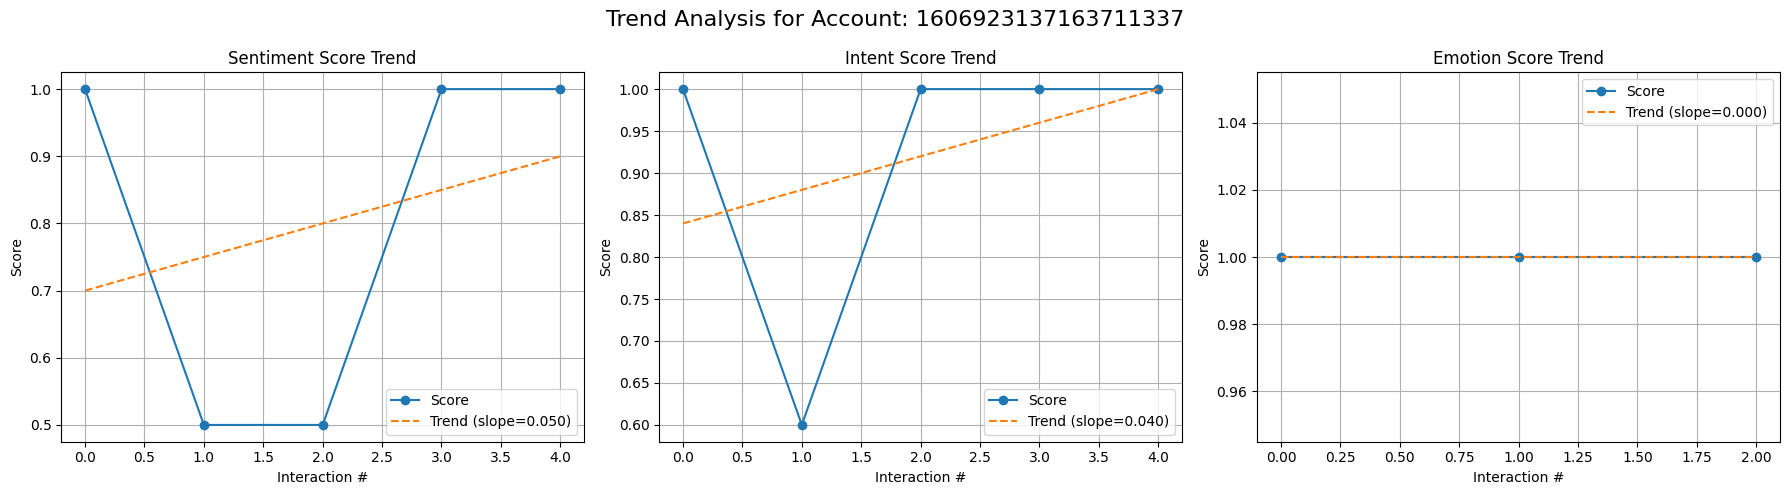

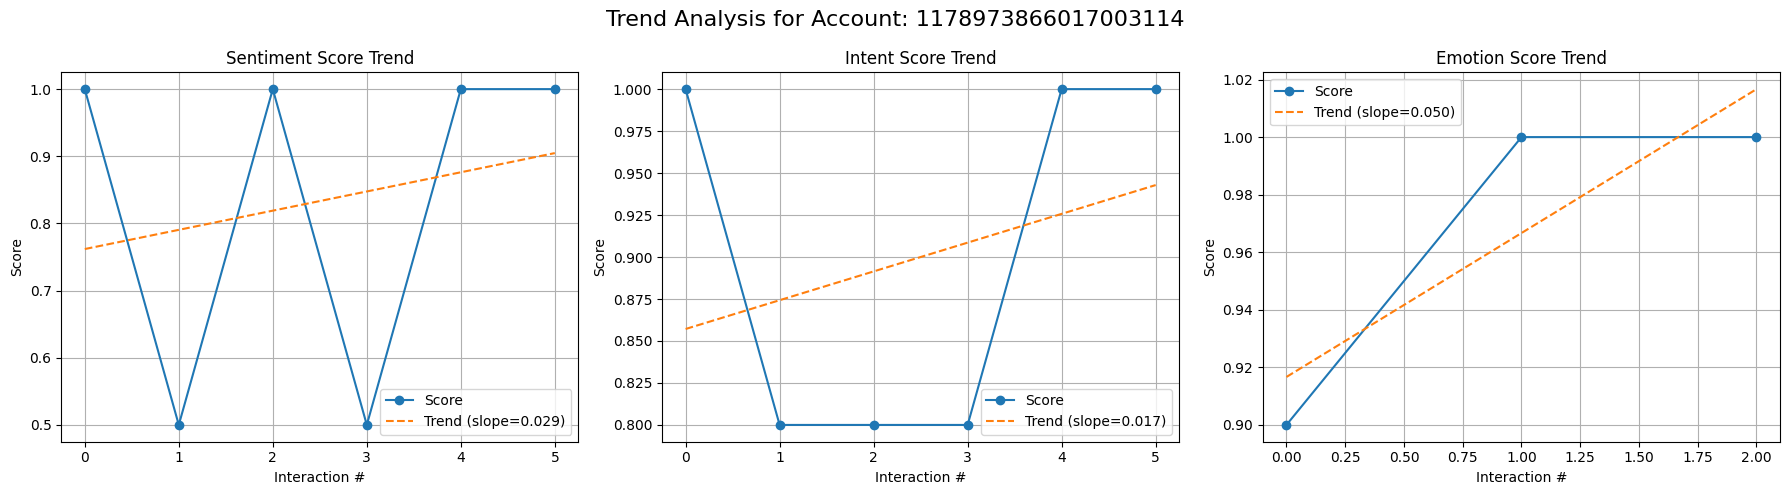

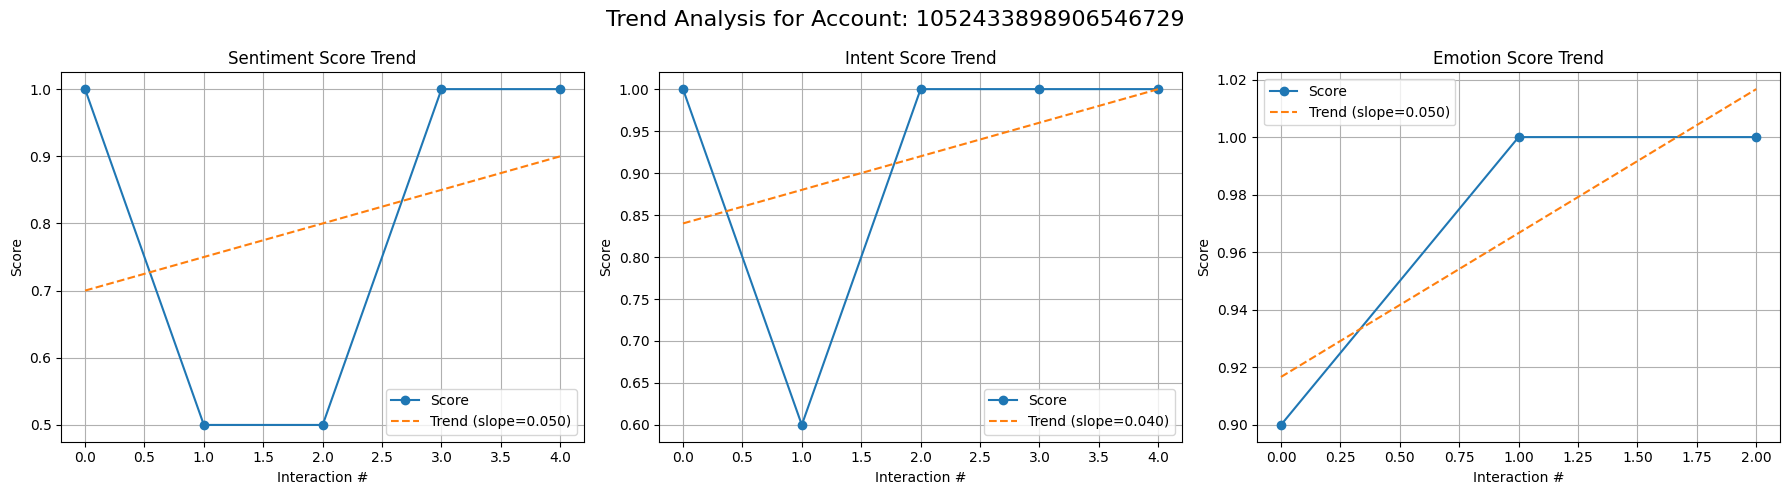


------Accounts with losing deals------



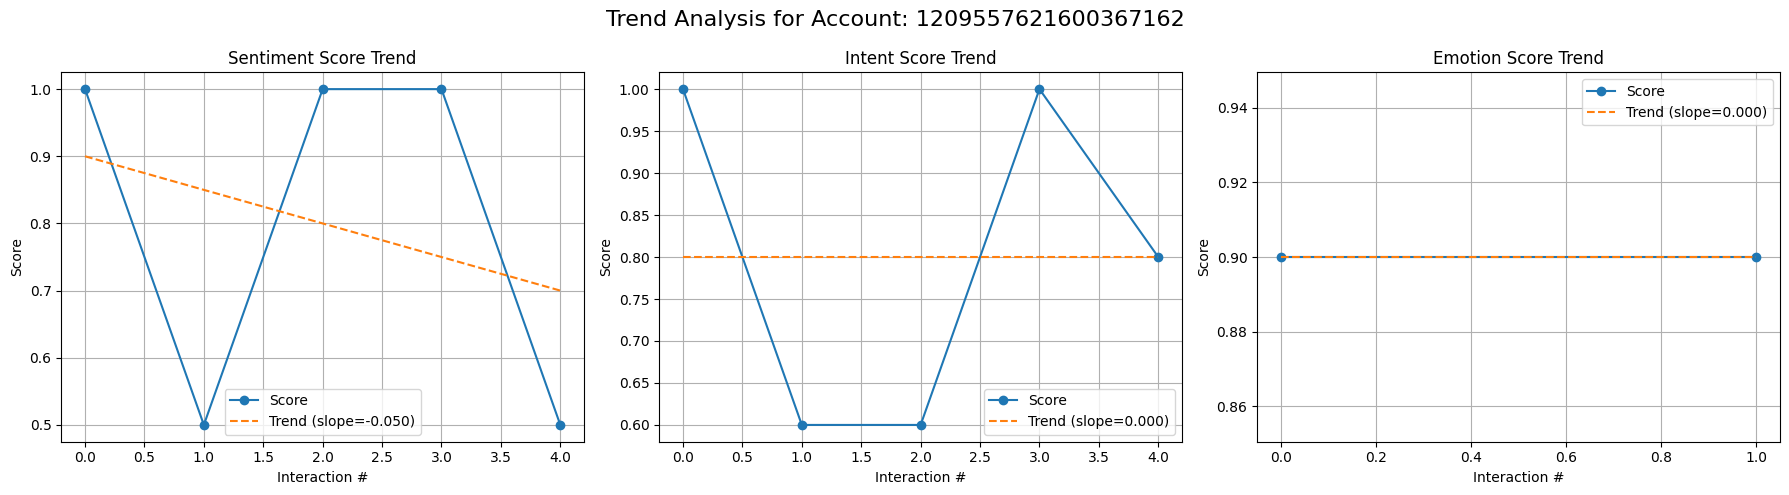

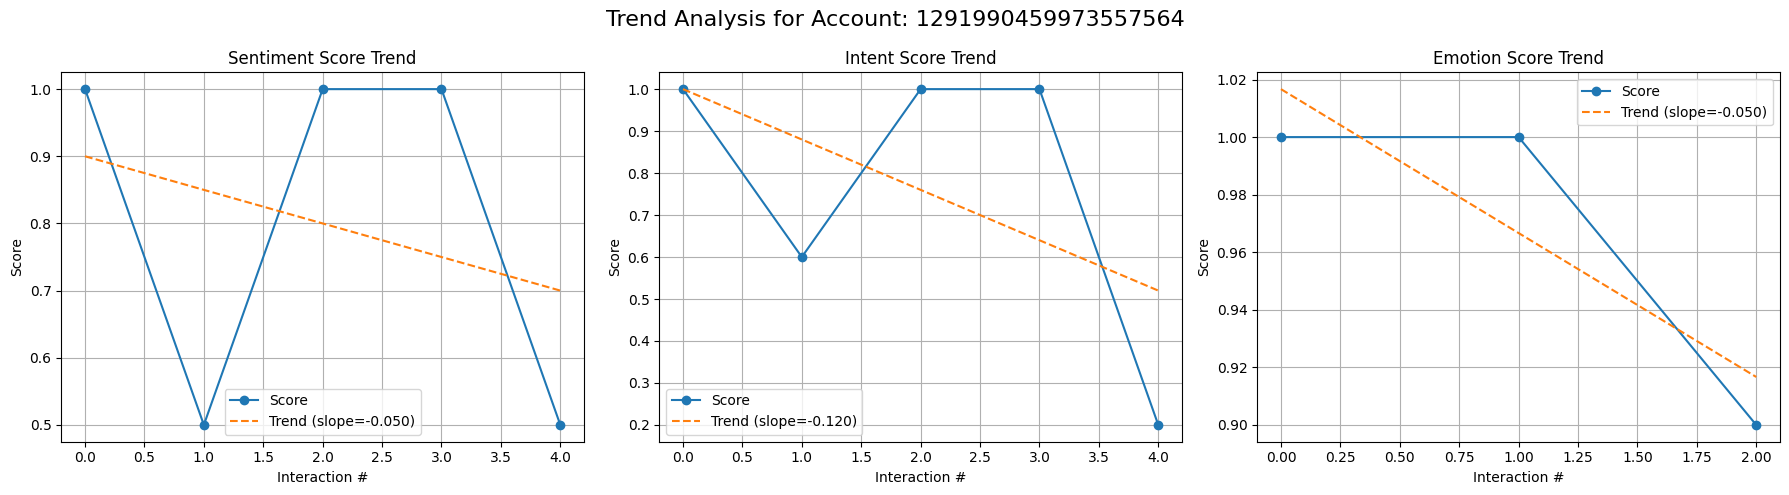

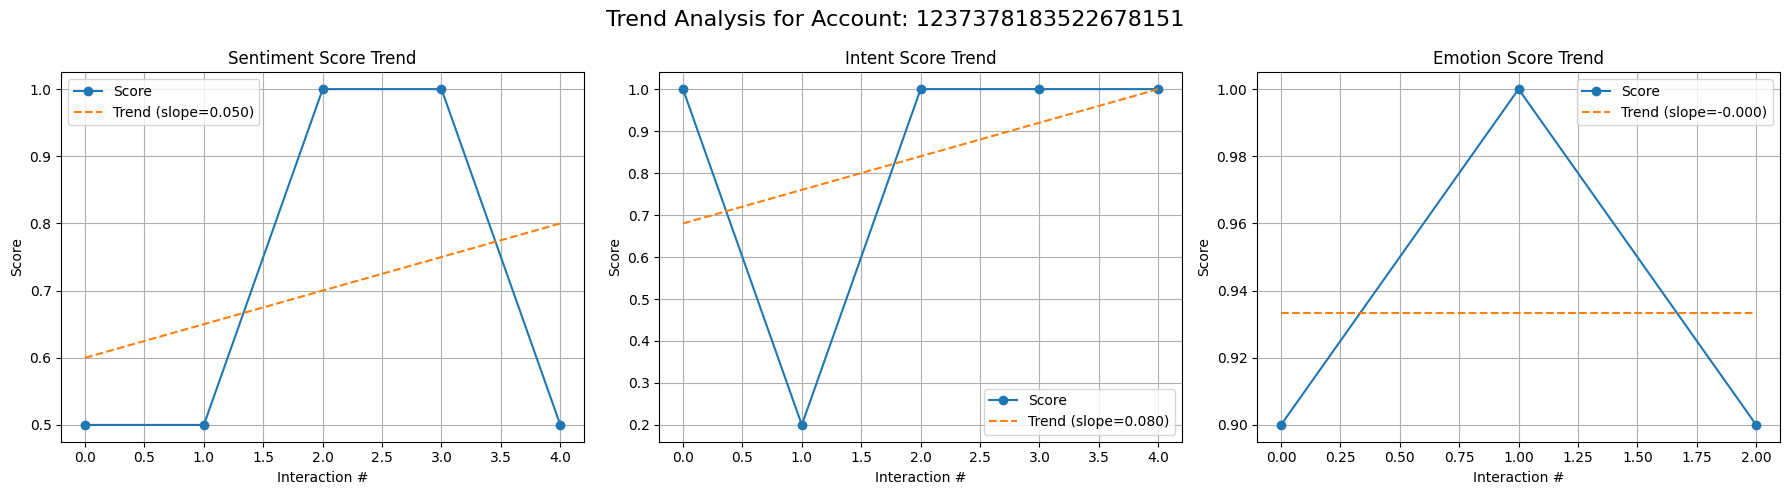

In [23]:
def plot_account_trends(df, account_id):
    account_df = df[df["account_id"] == account_id].sort_values("timestamp")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    score_types = ["sentiment_score", "intent_score", "emotion_score"]
    titles = ["Sentiment Score Trend", "Intent Score Trend", "Emotion Score Trend"]

    for i, score_type in enumerate(score_types):
        scores = account_df[score_type].dropna().tolist()
        if len(scores) < 2:
            axs[i].set_title(f"{titles[i]} (Not enough data)")
            axs[i].set_xlabel("Interaction #")
            axs[i].set_ylabel("Score")
            axs[i].grid(True)
            continue

        x = np.arange(len(scores)).reshape(-1, 1)
        y = np.array(scores).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        trend_line = model.predict(x)

        axs[i].plot(x, y, marker='o', label="Score")
        axs[i].plot(x, trend_line, linestyle='--', label=f"Trend (slope={model.coef_[0][0]:.3f})")
        axs[i].set_title(titles[i])
        axs[i].set_xlabel("Interaction #")
        axs[i].set_ylabel("Score")
        axs[i].legend()
        axs[i].grid(True)

    fig.suptitle(f"Trend Analysis for Account: {account_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

print('\n------Accounts with winning deals------\n')
for i in closed_won:
    plot_account_trends(df, i)

print('\n------Accounts with losing deals------\n')

for i in closed_lost:
    plot_account_trends(df, i)

## Extracting features for account persona


In [8]:
def compute_trend(values):
    if len(values) < 2:
        return 0
    x = np.arange(len(values)).reshape(-1, 1)
    y = np.array(values).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    return model.coef_[0][0]

account_features = []
engagement_weights = {"call": 1, "email": 0.5, "meeting": 1, "invoice": 1, "salesorder": 1, "quote": 1}

for account_id, group in df.groupby("account_id"):
    num_deals = group["deal_id"].nunique()
    sum_deal_amount = group.drop_duplicates("deal_id")["deal_amount"].sum()
    deal_stages = group.drop_duplicates("deal_id")["deal_stage"].nunique()
    deal_win_rate = group[group["class_tag"] == "closed won"].shape[0] / group.shape[0] if group.shape[0] > 0 else 0
    activity_count = group.shape[0]

    # Trend-based scores across all activities in the account
    intent_score = compute_trend(group["intent_score"].dropna().tolist())
    sentiment_score = compute_trend(group["sentiment_score"].dropna().tolist())
    emotion_score = compute_trend(group["emotion_score"].dropna().tolist())

    # Activity frequency (average days between activities)
    timestamps = group.sort_values("timestamp")["timestamp"]

    if len(timestamps) > 1:
        gaps = timestamps.diff().dt.days.dropna()
        activity_frequency = gaps.mean()
    else:
        days_since_last = (pd.Timestamp.now() - timestamps.iloc[0]).days
        activity_frequency = days_since_last

    recency = (pd.Timestamp.now() - group["timestamp"].max()).days
    engagement_score = group["activity_type"].map(engagement_weights).sum()

    account_features.append({
        "account_id": account_id,
        "num_deals": num_deals,
        "sum_deal_amount": sum_deal_amount,
        "deal_stages": deal_stages,
        "deal_win_rate": deal_win_rate,
        "activity_count": activity_count,
        "recency": recency,
        "activity_frequency": activity_frequency,
        "engagement_score": engagement_score,
        "intent_score": intent_score,
        "sentiment_score": sentiment_score,
        "emotion_score": emotion_score
    })

features_df = pd.DataFrame(account_features)

## Binning Rules

In [9]:
binning_rules = {}

for column in ["num_deals", "sum_deal_amount", "deal_stages", "deal_win_rate", "activity_count", "recency", "activity_frequency", 'intent_score', 'emotion_score', 'sentiment_score', "engagement_score"]:
    values = features_df[column]
    if (column == "activity_frequency" or column == 'recency'):
        bins = {
            "q3": round(values.quantile(0.75), 2),
            "q2": round(values.quantile(0.50), 2),
            "q1": round(values.quantile(0.25), 2)
        }
    else:
        bins = {
            "q1": round(values.quantile(0.25), 2),
            "q2": round(values.quantile(0.50), 2),
            "q3": round(values.quantile(0.75), 2)
        }
    binning_rules[column] = bins

In [10]:
def bin_score(value, thresholds, reverse=False):
    if reverse:
        if value <= thresholds["q1"]:
            return 1.0
        elif value <= thresholds["q2"]:
            return 0.75
        elif value <= thresholds["q3"]:
            return 0.5
        else:
            return 0.2
    else:
        if value <= thresholds["q1"]:
            return 0.2
        elif value <= thresholds["q2"]:
            return 0.5
        elif value <= thresholds["q3"]:
            return 0.75
        else:
            return 1.0

## Computing final persona score based on weights of each feature scores

In [11]:
def compute_account_persona_score(account_features, weights, binning_rules):
    individual_scores = {}
    weighted_scores = []

    for key in binning_rules:
        thresholds = binning_rules[key]
        reverse = (key == "activity_frequency" or key == "recency")
        if key not in ["intent_score", "emotion_score", "sentiment_score"]:
            score = bin_score(account_features[key], thresholds, reverse)
        else:
            # Direct value for intent/emotion/sentiment
            score = account_features[key]
        individual_scores[key] = score
        weighted_scores.append(score * weights.get(key, 1.0))

    total_weight = sum(weights.values())
    final_score = sum(weighted_scores) / total_weight if total_weight else 0

    return {
        "account_id": account_features["account_id"],
        "final_persona_score": round(final_score, 3),
        "individual_feature_scores": individual_scores
    }

In [12]:
weights = {
    "num_deals": 1.0,
    "sum_deal_amount": 0.5,
    "deal_stages": 1.0,
    "deal_win_rate": 0.5,
    "activity_count": 1,
    "recency": 0.5,
    "activity_frequency": 1.0,
    "engagement_score": 1.0,
}

## Storing the result for comparison

In [13]:
scored_personas = [compute_account_persona_score(row, weights, binning_rules) for row in account_features]

result_df = [json_data for json_data in scored_personas]

flat_data = []
for row in result_df:
    base = {
        'account_id': row['account_id'],
        'final_persona_score': row['final_persona_score']
    }
    base.update(row['individual_feature_scores'])
    flat_data.append(base)

result_df = pd.DataFrame(flat_data)

## Comparsion of contact features scores and change in bins

In [14]:
df_before=pd.read_csv('scored_acc_personas_v1_new.csv')

In [15]:
def compute_trends(values):
    values = [v for v in values if v is not None and not np.isnan(v)]
    n = len(values)
    if n < 2:
        return 0.0, n
    x = np.arange(n).reshape(-1,1)
    y = np.array(values).reshape(-1,1)
    model = LinearRegression().fit(x, y)
    slope = float(model.coef_[0][0])
    return slope, n

def interpret_trend_slope(scores, feature_name="", semantic_neutral=0.5):
    clean = [s for s in scores if s is not None and not np.isnan(s)]
    n = len(clean)
    if n < 2:
        return {
            "label": "Insufficient Data",
            "norm_slope": 0.0,
            "slope_per_step": 0.0,
            "n": n,
            "avg_score": None,
            "thresholds": None,
            "behaviour": f"Not enough {feature_name} data to determine a trend."
        }

    slope, n = compute_trends(clean)
    norm_slope = slope * (n - 1)  # total change over period
    start = clean[0]
    end = clean[-1]
    avg = float(np.mean(clean))

    # Determine movement type
    if abs(norm_slope) < 1e-6:
        label = "No Change"
        if avg > semantic_neutral:
            behaviour = f"The account {feature_name} remained consistently positive."
        elif avg < semantic_neutral:
            behaviour = f"The account {feature_name} remained consistently negative."
        else:
            behaviour = f"The account {feature_name} stayed neutral throughout."
    else:
        if start < semantic_neutral and end > semantic_neutral:
            label = "Negative to Positive"
            behaviour = f"The account {feature_name} improved from negative to positive over time."
        elif start > semantic_neutral and end < semantic_neutral:
            label = "Positive to Negative"
            behaviour = f"The account {feature_name} declined from positive to negative over time."
        elif start > semantic_neutral and end > semantic_neutral:
            if norm_slope > 0:
                label = "Strengthening Positive"
                behaviour = f"The account {feature_name} became more positive."
            else:
                label = "Weakening Positive"
                behaviour = f"The account {feature_name} became less positive."
        elif start < semantic_neutral and end < semantic_neutral:
            if norm_slope > 0:
                label = "Strengthening Negative"
                behaviour = f"The account {feature_name} became more negative."
            else:
                label = "Weakening Negative"
                behaviour = f"The account {feature_name} became less negative."
        else:
            label = "Around Neutral"
            behaviour = f"The account {feature_name} stayed near neutral values."

    return {
        "label": label,
        "norm_slope": round(norm_slope, 4),
        "slope_per_step": round(slope, 5),
        "n": n,
        "avg_score": round(avg, 3),
        "thresholds": None,
        "behaviour": behaviour
    }


def get_original_bin_label(score, thresholds):
      if score == 0.2:
          return f"Poorly Engaged (<={thresholds['min']:.2f})"
      elif score == 0.5:
          return f"Moderately Engaged ({thresholds['min']:.2f} - {thresholds['avg']:.2f})"
      else:
          return f"Highly Engaged (>{thresholds['avg']:.2f})"

def get_updated_bin_label(score, thresholds):
      if score == 0.2:
          return f"Very Low Engagement (<={thresholds['q1']:.2f})"
      elif score == 0.5:
          return f"Moderately Low Engagement ({thresholds['q1']:.2f} - {thresholds['q2']:.2f})"
      elif score == 0.75:
          return f"Moderately High Engagement ({thresholds['q2']:.2f} - {thresholds['q3']:.2f})"
      else:
          return f"Very High Engagement (>{thresholds['q3']:.2f})"

original_binning_rules = {
 'num_deals': {'min': 1, 'avg': np.float64(1.0), 'max': 1},
 'sum_deal_amount': {'min': 0.0, 'avg': np.float64(0.0), 'max': 0.0},
 'deal_stages': {'min': 1, 'avg': np.float64(1.0), 'max': 1},
 'activity_count': {'min': 5, 'avg': np.float64(5.4), 'max': 7},
 'activity_frequency': {'max': 1.0, 'avg': np.float64(0.69), 'min': 0.0},
 'engagement_score': {'min': 3.0, 'avg': np.float64(3.2), 'max': 4.0}
}


In [16]:
pd.set_option('display.max_colwidth', None)

def compare_account_metrics(account_id_to_compare, df_before, result_df):
    account_before = df_before[df_before['account_id'] == account_id_to_compare].iloc[0]
    account_after = result_df[result_df['account_id'] == account_id_to_compare].iloc[0]

    features_to_bin = [
        'num_deals', 'sum_deal_amount', 'deal_stages', 'deal_win_rate', 'recency',
        'activity_count', 'activity_frequency', 'engagement_score',
        'intent_score', 'emotion_score', 'sentiment_score'
    ]

    rows = []

    for feat in features_to_bin:
        row = {
            "Feature": feat,
            "Original Threshold": None,
            "Original Score": None,
            "Original Bin": None,
            "Updated Threshold": None,
            "Updated Score": None,
            "Updated Bin": None,
            "Trend": None
        }

        # Original binning
        if feat in account_before and feat in original_binning_rules:
            score_before = account_before[feat]
            thresholds_original = original_binning_rules[feat]
            bin_label_original = get_original_bin_label(score_before, thresholds_original)
            row["Original Threshold"] = str(thresholds_original)
            row["Original Score"] = round(float(score_before), 2)
            row["Original Bin"] = bin_label_original

        # Updated binning or trend
        if feat in ["intent_score", "emotion_score", "sentiment_score"]:
            group = df[df["account_id"] == account_id_to_compare]
            scores = group[feat].dropna().tolist()
            trend_info = interpret_trend_slope(scores, feature_name=feat.replace("_score", ""))
            row["Updated Score"] = trend_info["norm_slope"]
            row["Updated Bin"] = trend_info["label"]
            row["Trend"] = trend_info["behaviour"]
        elif feat in account_after and feat in binning_rules:
            score_after = account_after[feat]
            thresholds_updated = binning_rules[feat]
            bin_label_updated = get_updated_bin_label(score_after, thresholds_updated)
            row["Updated Threshold"] = str(thresholds_updated)
            row["Updated Score"] = round(float(score_after), 2)
            row["Updated Bin"] = bin_label_updated

        rows.append(row)

    return pd.DataFrame(rows)

df_metrics = compare_account_metrics(1061426914652920268, df_before, result_df)
display(df_metrics)

,Feature,Original Threshold,Original Score,Original Bin,Updated Threshold,Updated Score,Updated Bin,Trend
0,num_deals,"{'min': 1, 'avg': np.float64(1.0), 'max': 1}",0.2,Poorly Engaged (<=1.00),"{'q1': np.float64(1.0), 'q2': np.float64(1.0), 'q3': np.float64(1.0)}",0.20,Very Low Engagement (<=1.00),None
1,sum_deal_amount,"{'min': 0.0, 'avg': np.float64(0.0), 'max': 0.0}",0.2,Poorly Engaged (<=0.00),"{'q1': np.float64(0.0), 'q2': np.float64(0.0), 'q3': np.float64(0.0)}",0.20,Very Low Engagement (<=0.00),None
2,deal_stages,"{'min': 1, 'avg': np.float64(1.0), 'max': 1}",0.2,Poorly Engaged (<=1.00),"{'q1': np.float64(1.0), 'q2': np.float64(1.0), 'q3': np.float64(1.0)}",0.20,Very Low Engagement (<=1.00),None
3,deal_win_rate,None,NaN,None,"{'q1': np.float64(0.0), 'q2': np.float64(1.0), 'q3': np.float64(1.0)}",0.20,Very Low Engagement (<=0.00),None
4,recency,None,NaN,None,"{'q3': np.float64(44.25), 'q2': np.float64(38.0), 'q1': np.float64(29.0)}",1.00,Very High Engagement (>44.25),None
5,activity_count,"{'min': 5, 'avg': np.float64(5.4), 'max': 7}",0.2,Poorly Engaged (<=5.00),"{'q1': np.float64(5.0), 'q2': np.float64(5.0), 'q3': np.float64(5.0)}",0.20,Very Low Engagement (<=5.00),None
6,activity_frequency,"{'max': 1.0, 'avg': np.float64(0.69), 'min': 0.0}",0.5,Moderately Engaged (0.00 - 0.69),"{'q3': np.float64(0.75), 'q2': np.float64(0.75), 'q1': np.float64(0.5)}",1.00,Very High Engagement (>0.75),None
7,engagement_score,"{'min': 3.0, 'avg': np.float64(3.2), 'max': 4.0}",0.2,Poorly Engaged (<=3.00),"{'q1': np.float64(3.0), 'q2': np.float64(3.0), 'q3': np.float64(3.0)}",0.20,Very Low Engagement (<=3.00),None
8,intent_score,None,NaN,None,None,-0.64,Positive to Negative,The account intent declined from positive to negative over time.
9,emotion_score,None,NaN,None,None,-0.10,Weakening Positive,The account emotion became less positive.


## JSON output for 5 accounts

In [24]:
def add_labels_to_personas(scored_personas, binning_rules, get_updated_bin_label, interpret_trend_slope):
    """
    Adds bin labels to scored_personas JSON using updated binning rules.
    """
    updated_personas = []

    for persona in scored_personas:
        new_persona = persona.copy()
        labels = {}
        account_id = persona["account_id"]

        for feat, score in persona["individual_feature_scores"].items():
            if feat in binning_rules:
                if feat in ["intent_score", "emotion_score", "sentiment_score"]:
                  group = df[df["account_id"] == account_id]
                  scores = group[feat].dropna().tolist()
                  bin_label = interpret_trend_slope(scores, feat)
                  labels[feat] = bin_label['label']
                  # behaviour = bin_label['behaviour']
                else:
                  thresholds = binning_rules[feat]
                  bin_label = get_updated_bin_label(score, thresholds)
                  labels[feat] = bin_label


        new_persona["labels"] = labels
        # new_persona["behaviour"] = behaviour
        updated_personas.append(new_persona)

    return updated_personas

import pprint

accounts_map = {
    "winning deals": closed_won,
    "losing deals": closed_lost
}

for label, account_list in accounts_map.items():
    print(f"\n------Accounts with {label}------\n")

    filtered_personas = [
        persona for persona in scored_personas
        if persona.get("account_id") in account_list
    ]

    scored_personas_with_labels = add_labels_to_personas(
        filtered_personas,
        binning_rules,
        get_updated_bin_label,
        interpret_trend_slope
    )

    pprint.pprint(scored_personas_with_labels)


------Accounts with winning deals------

[{'account_id': 1052433898906546729,
  'final_persona_score': np.float64(0.287),
  'individual_feature_scores': {'activity_count': 0.2,
                                'activity_frequency': 0.2,
                                'deal_stages': 0.2,
                                'deal_win_rate': 0.5,
                                'emotion_score': np.float64(0.049999999999999954),
                                'engagement_score': 0.2,
                                'intent_score': np.float64(0.04),
                                'num_deals': 0.2,
                                'recency': 0.75,
                                'sentiment_score': np.float64(0.04999999999999998),
                                'sum_deal_amount': 0.2},
  'labels': {'activity_count': 'Very Low Engagement (<=5.00)',
             'activity_frequency': 'Very Low Engagement (<=0.50)',
             'deal_stages': 'Very Low Engagement (<=1.00)',
             'deal_wi

## Comparision of change in bins of all features between current version and updated version as charts

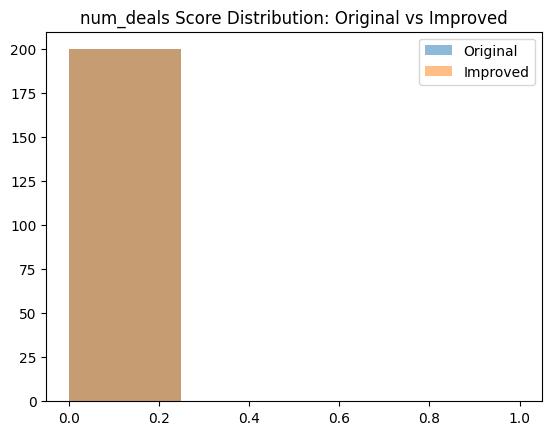

       num_deals_before  num_deals_after
count      2.000000e+02     2.000000e+02
mean       2.000000e-01     2.000000e-01
std        1.391261e-16     1.391261e-16
min        2.000000e-01     2.000000e-01
25%        2.000000e-01     2.000000e-01
50%        2.000000e-01     2.000000e-01
75%        2.000000e-01     2.000000e-01
max        2.000000e-01     2.000000e-01


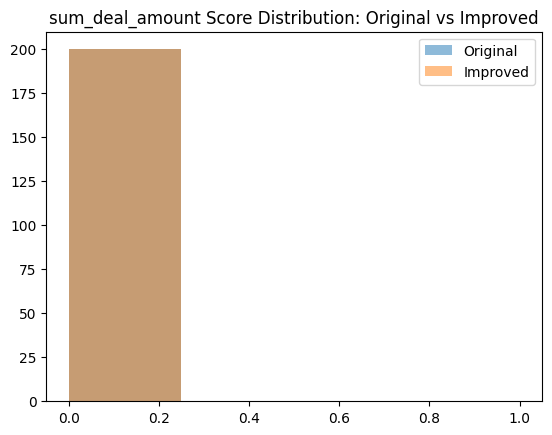

       sum_deal_amount_before  sum_deal_amount_after
count            2.000000e+02           2.000000e+02
mean             2.000000e-01           2.000000e-01
std              1.391261e-16           1.391261e-16
min              2.000000e-01           2.000000e-01
25%              2.000000e-01           2.000000e-01
50%              2.000000e-01           2.000000e-01
75%              2.000000e-01           2.000000e-01
max              2.000000e-01           2.000000e-01


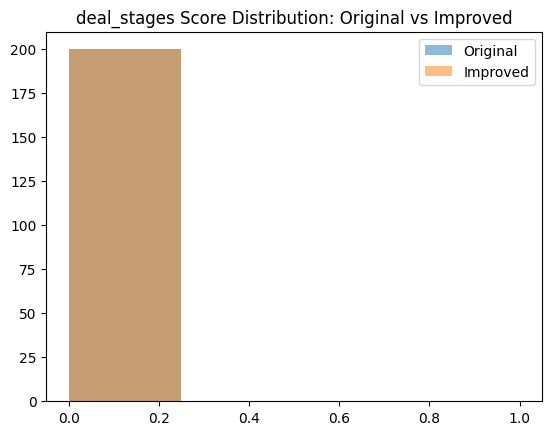

       deal_stages_before  deal_stages_after
count        2.000000e+02       2.000000e+02
mean         2.000000e-01       2.000000e-01
std          1.391261e-16       1.391261e-16
min          2.000000e-01       2.000000e-01
25%          2.000000e-01       2.000000e-01
50%          2.000000e-01       2.000000e-01
75%          2.000000e-01       2.000000e-01
max          2.000000e-01       2.000000e-01


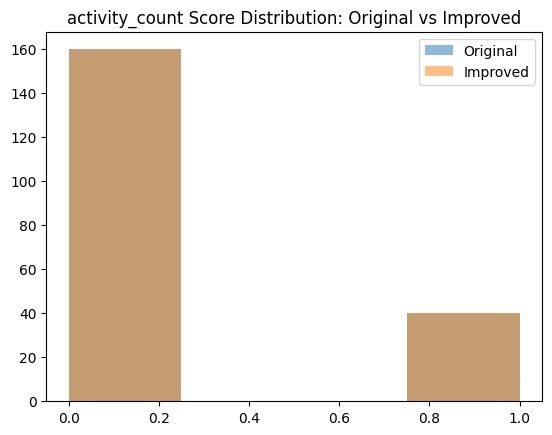

       activity_count_before  activity_count_after
count             200.000000            200.000000
mean                0.360000              0.360000
std                 0.320803              0.320803
min                 0.200000              0.200000
25%                 0.200000              0.200000
50%                 0.200000              0.200000
75%                 0.200000              0.200000
max                 1.000000              1.000000


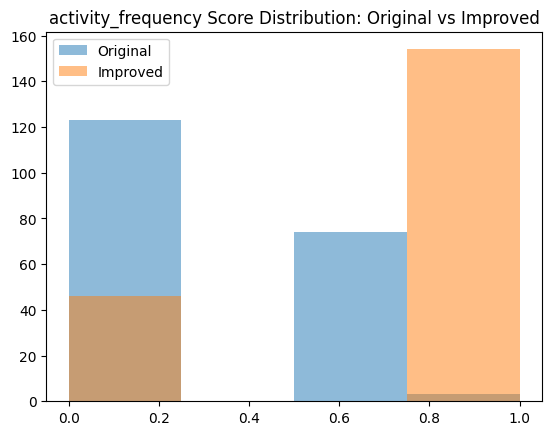

       activity_frequency_before  activity_frequency_after
count                 200.000000                 200.00000
mean                    0.323000                   0.70100
std                     0.167065                   0.29493
min                     0.200000                   0.20000
25%                     0.200000                   0.75000
50%                     0.200000                   0.75000
75%                     0.500000                   1.00000
max                     1.000000                   1.00000


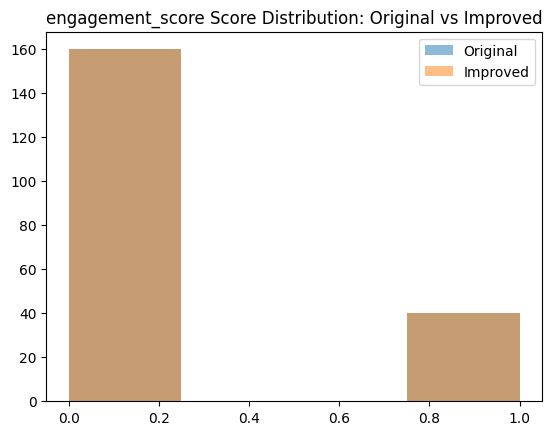

       engagement_score_before  engagement_score_after
count               200.000000              200.000000
mean                  0.360000                0.360000
std                   0.320803                0.320803
min                   0.200000                0.200000
25%                   0.200000                0.200000
50%                   0.200000                0.200000
75%                   0.200000                0.200000
max                   1.000000                1.000000


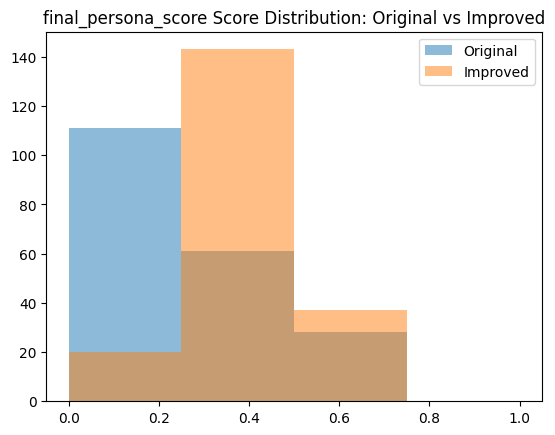

       final_persona_score_before  final_persona_score_after
count                  200.000000                 200.000000
mean                     0.280590                   0.375455
std                      0.128876                   0.121675
min                      0.200000                   0.132000
25%                      0.200000                   0.303250
50%                      0.200000                   0.349000
75%                      0.255000                   0.410000
max                      0.636000                   0.672000


In [18]:
compare_df = df_before.merge(
    result_df,
    on="account_id",
    suffixes=("_before", "_after")
)

features = ['num_deals', 'sum_deal_amount', 'deal_stages',
            'activity_count', 'activity_frequency', 'engagement_score', 'final_persona_score']

for metric in features:
  min_val = min(df_before[f'{metric}'].min(), result_df[f'{metric}'].min())
  max_val = max(df_before[f'{metric}'].max(), result_df[f'{metric}'].max())
  bins = np.linspace(0, 1, 5)

  plt.hist(df_before[f'{metric}'], bins=bins, alpha=0.5, label='Original')
  plt.hist(result_df[f'{metric}'], bins=bins, alpha=0.5, label='Improved')
  plt.legend()
  plt.title(f"{metric} Score Distribution: Original vs Improved")
  plt.show()

  print(compare_df[[f'{metric}_before', f'{metric}_after']].describe())


## Prediction

In [19]:
def score_new_account(account_id, contact_records, deal_records, activity_records, weights, binning_rules, engagement_weights):
    df_contacts = pd.DataFrame(contact_records)
    df_deals = pd.DataFrame(deal_records)
    df_activities = pd.DataFrame(activity_records)

    # Merge contacts and activities first to bring account_id into the activity data
    merged = pd.merge(df_activities, df_deals, on="deal_id")
    merged = pd.merge(merged, df_contacts, on="contact_id")

    # Filter for the given account_id
    merged = merged[merged["account_id"] == account_id]

    # Map scores
    merged["sentiment_score"] = merged["sentiment"].map(sentiment_map)
    merged["intent_score"] = merged["intent"].map(intent_map)
    merged["emotion_score"] = merged["emotion"].map(emotion_map)

    # Aggregate account-level metrics
    num_deals = merged["deal_id"].nunique()
    sum_deal_amount = merged.drop_duplicates("deal_id")["deal_amount"].sum()
    deal_win_rate = merged[merged["class_tag"] == "closed won"].shape[0] / merged.shape[0] if merged.shape[0] > 0 else 0
    deal_stages_count = merged.drop_duplicates("deal_id")["deal_stage"].nunique()
    activity_count = merged.shape[0]

    # Trend scores
    intent_score_trend = compute_trend(merged["intent_score"].dropna().tolist())
    sentiment_score_trend = compute_trend(merged["sentiment_score"].dropna().tolist())
    emotion_score_trend = compute_trend(merged["emotion_score"].dropna().tolist())

    # Activity frequency
    timestamps = merged.sort_values("timestamp")["timestamp"]

    if len(timestamps) > 1:
        gaps = timestamps.diff().dt.days.dropna()
        activity_frequency = gaps.mean()
    else:
        days_since_last = (pd.Timestamp.now() - timestamps.iloc[0]).days
        activity_frequency = days_since_last

    recency = (pd.Timestamp.now() - merged["timestamp"].max()).days
    engagement_score = merged["activity_type"].map(engagement_weights).sum()

    # Feature dictionary for account
    account_features = {
        "account_id": account_id,
        "num_deals": num_deals,
        "sum_deal_amount": sum_deal_amount,
        "deal_stages": deal_stages_count,
        "deal_win_rate": deal_win_rate,
        "recency": recency,
        "activity_count": activity_count,
        "activity_frequency": activity_frequency,
        "engagement_score": engagement_score,
        "intent_score": intent_score_trend,
        "sentiment_score": sentiment_score_trend,
        "emotion_score": emotion_score_trend
    }

    return compute_account_persona_score(account_features, weights, binning_rules)

In [20]:
example_deal_records = [
    {"deal_id": "DX1", "contact_id": "C1", "deal_amount": 9000, "deal_stage": "Proposal", "class_tag": "closed won"},
    {"deal_id": "DX2", "contact_id": "C1", "deal_amount": 14000, "deal_stage": "Won", "class_tag": "closed lost"},
    {"deal_id": "DX3", "contact_id": "C2", "deal_amount": 3000, "deal_stage": "Negotiation", "class_tag": "closed lost"}
]

example_contact_records = [
    {"contact_id": "C1", "account_id": "AC101"},
    {"contact_id": "C2", "account_id": "AC101"},
    {"contact_id": "C3", "account_id": "AC102"}
]

example_activity_records = [
    {
        "deal_id": "DX1",
        "activity_type": "call",
        "timestamp": datetime.now() - timedelta(days=5),
        "intent": "Request",
        "emotion": "Neutral",
        "sentiment": "Neutral"
    },
    {
        "deal_id": "DX1",
        "activity_type": "email",
        "timestamp": datetime.now() - timedelta(days=3),
        "intent": "Request",
        "emotion": "Happy",
        "sentiment": "Positive"
    },
    {
        "deal_id": "DX2",
        "activity_type": "meeting",
        "timestamp": datetime.now() - timedelta(days=1),
        "intent": "Purchase",
        "emotion": "Enthusiasm",
        "sentiment": "Positive"
    },
    {
        "deal_id": "DX3",
        "activity_type": "email",
        "timestamp": datetime.now() - timedelta(days=2),
        "intent": "Gratitude",
        "emotion": "Neutral",
        "sentiment": "Neutral",
    }
]

In [21]:
new_account_score = score_new_account("AC101", example_contact_records, example_deal_records, example_activity_records, weights, binning_rules, engagement_weights)
print("\nScored new account:")
print(json.dumps(new_account_score, indent=2))


Scored new account:
{
  "account_id": "AC101",
  "final_persona_score": 0.6,
  "individual_feature_scores": {
    "num_deals": 1.0,
    "sum_deal_amount": 1.0,
    "deal_stages": 1.0,
    "deal_win_rate": 0.5,
    "activity_count": 0.2,
    "recency": 1.0,
    "activity_frequency": 0.2,
    "intent_score": 0.04999999999999998,
    "emotion_score": -3.925231146709437e-17,
    "sentiment_score": -1.2412670766236365e-17,
    "engagement_score": 0.2
  }
}
